In [ ]:
from typing import Literal

import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from matplotlib.colors import BoundaryNorm
from numpy.typing import NDArray
from pyproj import Transformer
from rasterio.windows import from_bounds

In [20]:
SUFOSAT_V2_RASTER_DATES = "../../data/mosaics_tropisco_warnings_france_date.tif"
SUFOSAT_V3_RASTER_DATES = "../../data/forest-clearcuts_mainland-france_sufosat_dates_v3.tif"
HSD_RASTER_DATES = "../../data/hsd_France.tif"

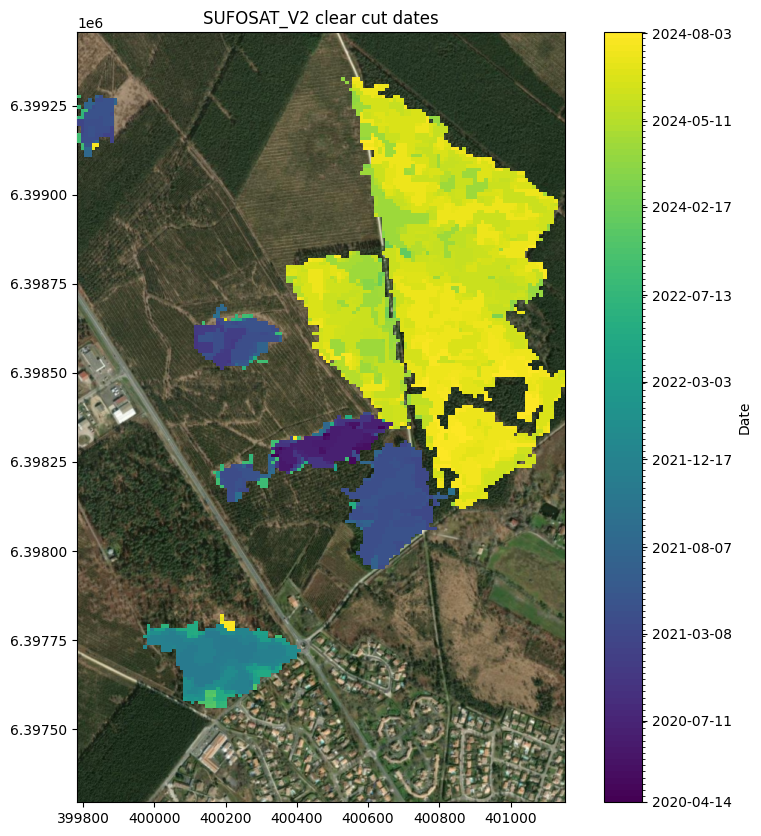

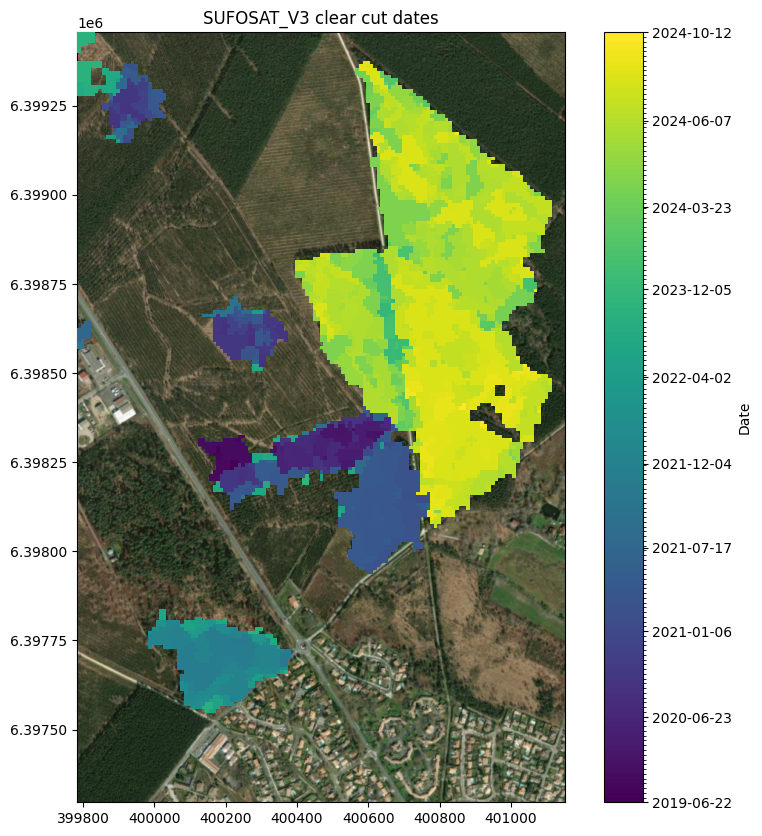

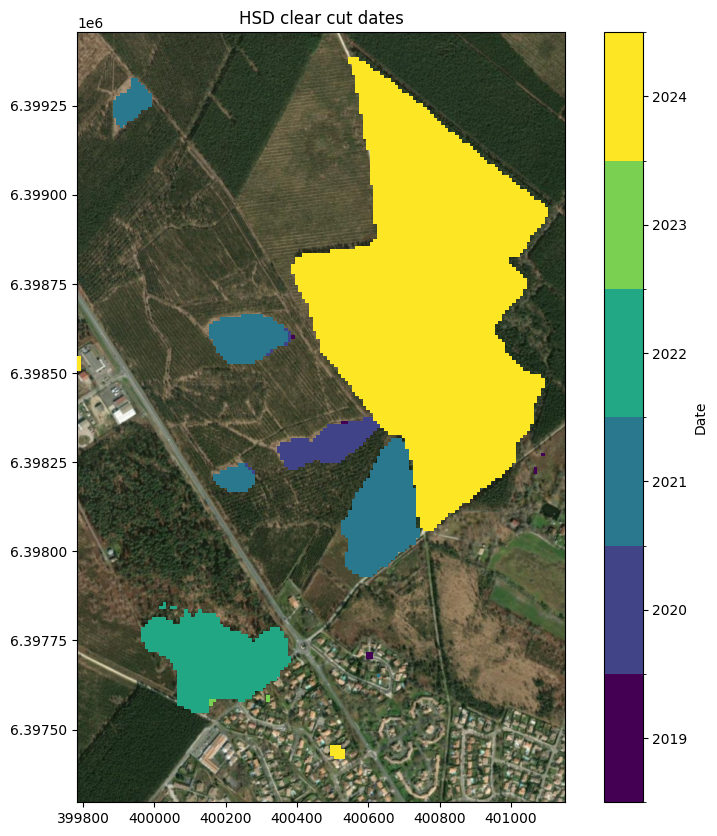

In [28]:
def load_raster_subset(
    raster_path: str,
    minx: float,
    maxx: float,
    miny: float,
    maxy: float,
) -> tuple[NDArray[np.floating], tuple[float]]:
    # Load a subset of a raster file based on given bounds.
    with rasterio.open(raster_path) as src:
        window = from_bounds(
            left=minx, bottom=miny, right=maxx, top=maxy, transform=src.transform
        )
        data = src.read(1, window=window)

        # Get updated transform for the subset
        transform = src.window_transform(window)

    # Prepare data for plotting
    data = data.astype(float)
    data[data == 0] = np.nan

    # Compute extent for imshow
    left, top = transform * (0, 0)  # Upper-left corner in world coordinates
    right, bottom = transform * (data.shape[1], data.shape[0])  # Lower-right corner
    extent = (left, right, bottom, top)

    return data, extent


def parse_sufosat_v3_date(sufosat_date: float) -> pd.Timestamp:
    sufosat_date = int(sufosat_date)
    return pd.Timestamp(year=2000 + sufosat_date // 1000, month=1, day=1) + pd.Timedelta(
        days=(sufosat_date % 1000) - 1
    )


def parse_sufosat_v2_date(sufosat_date: float) -> pd.Timestamp:
    sufosat_date = int(sufosat_date)
    SUFOSAT_START_DATE = pd.Timestamp(year=2014, month=4, day=3)
    return SUFOSAT_START_DATE + pd.Timedelta(days=sufosat_date)


def plot_raster_dates(
    data: NDArray[np.floating],
    extent: tuple[float],
    clear_cut: gpd.GeoDataFrame | None = None,
    raster_source: Literal["sufosat_v2", "sufosat_v3", "hsd"] = "sufosat_v2",
    max_ticks: int = 10,  # Maximum number of tick labels to show
) -> None:
    # Set up color mapping
    categories_thresholds = np.unique(data[~np.isnan(data)])
    if len(categories_thresholds) < 2:
        categories_thresholds = np.array(
            [categories_thresholds[0] - 1, categories_thresholds[0] + 1]
        )

    # Create a proper colormap with the right number of colors
    num_categories = len(categories_thresholds)
    cmap = plt.colormaps["viridis"].resampled(num_categories)

    # For discrete categories, we need to create boundaries between categories
    bounds = np.concatenate(
        [
            [categories_thresholds[0] - 0.5],  # Add lower bound
            categories_thresholds[:-1]
            + np.diff(categories_thresholds) / 2,  # Middle boundaries
            [categories_thresholds[-1] + 0.5],  # Add upper bound
        ]
    )

    norm = BoundaryNorm(boundaries=bounds, ncolors=num_categories)

    # Create plot
    fig, ax = plt.subplots(figsize=(10, 10))

    img = ax.imshow(data, cmap=cmap, norm=norm, extent=extent, zorder=10)
    cx.add_basemap(
        ax,
        source=cx.providers.Esri.WorldImagery,
        crs="EPSG:2154",
        attribution=False,
    )

    # Configure colorbar with dates
    cbar = plt.colorbar(img)

    # If there are too many categories, show a subset of ticks
    if num_categories > max_ticks:
        # Choose a subset of indices that are approximately evenly spaced
        tick_indices = np.linspace(0, num_categories - 1, max_ticks, dtype=int)
        tick_values = categories_thresholds[tick_indices]
    else:
        tick_values = categories_thresholds

    # Generate labels for selected ticks
    if raster_source == "sufosat_v2":
        tick_labels = [parse_sufosat_v2_date(tick).strftime("%Y-%m-%d") for tick in tick_values]
    elif raster_source == "sufosat_v3":
        tick_labels = [parse_sufosat_v3_date(tick).strftime("%Y-%m-%d") for tick in tick_values]
    elif raster_source == "hsd":
        tick_labels = [f"{int(tick)}" for tick in tick_values]

    cbar.set_ticks(tick_values)
    cbar.set_ticklabels(tick_labels)
    cbar.set_label("Date")

    # Plot the clear cut polygon
    if clear_cut is not None:
        clear_cut.to_crs(epsg=4326).plot(ax=ax, facecolor="none", edgecolor="red", linewidth=1)

    plt.title(f"{raster_source.upper()} clear cut dates")
    plt.show()


# Define the transformation from WGS 84 (EPSG:4326) to Lambert-93 (EPSG:2154)
transformer = Transformer.from_crs("EPSG:4326", "EPSG:2154", always_xy=True)

# Bounding box
minx, miny = transformer.transform(-0.785, 44.61)
maxx, maxy = transformer.transform(-0.769, 44.63)

# SUFOSAT v2 is in WGS84
data_sv2, extent_sv2 = load_raster_subset(
    raster_path=SUFOSAT_V2_RASTER_DATES,
    minx=-0.785,
    maxx=-0.769,
    miny=44.61,
    maxy=44.63,
)
# Convert to Lambert-93
x1, y1 = transformer.transform(extent_sv2[0], extent_sv2[2])  # (lon1, lat1)
x2, y2 = transformer.transform(extent_sv2[1], extent_sv2[3])  # (lon2, lat2)
extent_sv2_lambert93 = [x1, x2, y1, y2]
plot_raster_dates(
    data_sv2,
    extent_sv2_lambert93,
    raster_source="sufosat_v2",
)


plot_raster_dates(
    *load_raster_subset(
        raster_path=SUFOSAT_V3_RASTER_DATES,
        minx=minx,
        maxx=maxx,
        miny=miny,
        maxy=maxy,
    ),
    raster_source="sufosat_v3",
)

plot_raster_dates(
    *load_raster_subset(
        raster_path=HSD_RASTER_DATES,
        minx=minx,
        maxx=maxx,
        miny=miny,
        maxy=maxy,
    ),
    raster_source="hsd",
)